# Cube style analysis with Gammapy and Sherpa

This notebook is a proof of concept for a cube style analysis using Gammapy and Sherpa.

To prepare the counts and exposure cubes, please run the ```prepare_data_cubes.py``` script first.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np

from sherpa.models import NormGauss2D, PowLaw1D, TableModel, Const2D
from sherpa.stats import Cash, Chi2ConstVar
from sherpa.optmethods import LevMar, NelderMead
from sherpa.fit import Fit

from gammapy.cube.sherpa_ import Data3D, CombinedModel3D
from gammapy.cube import SkyCube
from gammapy.utils.energy import EnergyBounds

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord

In [3]:
# Set up data cube
counts = SkyCube.read('counts.fits.gz', format='fermi-counts')
cube = counts.to_sherpa_data3d()

In [4]:
# Set up exposure table model
exposure_data = fits.getdata('exposure.fits.gz')
exposure = TableModel('exposure')
exposure.load(None, exposure_data.ravel())

# Freeze exposure amplitude
exposure.ampl.freeze()

In [5]:
# Setup combined spatial and spectral model
spatial_model = NormGauss2D('spatial-model')
spectral_model = PowLaw1D('spectral-model')
source_model = CombinedModel3D(spatial_model=spatial_model, spectral_model=spectral_model)

# Set starting values
source_model.gamma = 2.2
source_model.xpos = 83.6
source_model.ypos = 22.01
source_model.fwhm = 0.12
source_model.ampl = 0.05

# Adding this constant background components the fit works with cash statistics as well
#spatial_model_bkg = Const2D('spatial-model-bkg')
#spectral_model_bkg = PowLaw1D('spectral-model-bkg')
#bkg_model = CombinedModel3D(spatial_model=spatial_model_bkg, spectral_model=spectral_model_bkg)

model = 1E-9 * exposure * (source_model) # 1E-9 flux factor

In [6]:
# Fit
# For now only Chi2 statistics seems to work, using Cash, the optimizer doesn't run at all,
# maybe because of missing background model?
fit = Fit(data=cube, model=model, stat=Chi2ConstVar(), method=LevMar())
result = fit.fit()

In [7]:
print(result)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2constvar
succeeded      = True
parnames       = ('spatial-model.fwhm', 'spatial-model.xpos', 'spatial-model.ypos', 'spatial-model.ampl', 'spectral-model.gamma')
parvals        = (0.12155630562273063, 83.625627113810722, 22.015563577095811, 0.096903046875814178, 2.2409890663883951)
statval        = 326658.84925
istatval       = 334850.945397
dstatval       = 8192.09614707
numpoints      = 320000
dof            = 319995
qval           = 6.49987737177e-17
rstat          = 1.02082485429
message        = successful termination
nfev           = 61


# Data image

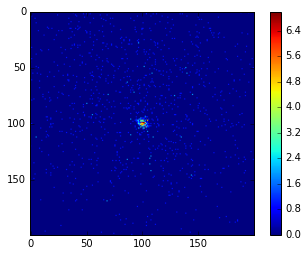

In [8]:
counts_ = cube.get_dep().reshape(cube.shape).sum(axis=0)
plt.imshow(counts_)
plt.colorbar()

# Morphology model image

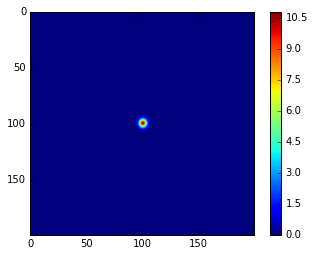

In [9]:
model_ = cube.eval_model(source_model).reshape(cube.shape).sum(axis=0)
plt.imshow(model_)
plt.colorbar()

# Position check

In [12]:
# Check position with reference position to verify wcs
crab_position_ref = SkyCoord.from_name('crab')
crab_position = SkyCoord(source_model.xpos.val, source_model.ypos.val, frame='icrs', unit='deg')
assert crab_position.separation(crab_position_ref) < Quantity(0.01, 'deg') # 1/2 pixel accuracy